# Setup

In [6]:
# ! pip install numpy matplotlib tqdm

In [7]:
import logging
import numpy as np
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict

from env import Environment
from logger import setup_custom_logger

# Variable declaration

In [8]:
logger = setup_custom_logger('easy21')
logger.setLevel(logging.WARN)

In [9]:
env = Environment(logger)

# Definitions

## Auxiliary functions

In [10]:
def static_policy(state):
    """Sticks to any sum >= 17"""
    return 0 if state[1] < 17 else 1

def random_policy(state):
    """Generate action according to uniform probability"""
    return np.random.choice(len(state))

In [11]:
def make_epsilon_greedy_policy(Q, N, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        N: A dictionary that maps from state -> counts.
            Each value is a numpy array of length nA (see below). Used to calculate epsilon value for easy21 assignment.
        nA: An integer that represents action space length
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    N0 = 100 # Constant for calculating epsilon value
    def new_policy(state):
        epsilon = N0 / (N0 + np.sum(N[state]))
        A = np.full(nA, epsilon / nA)
        best_action = np.argmax(Q[state]) # id of most valuable action
        A[best_action] += 1 - epsilon
        return A
    
    return new_policy

In [12]:
def make_greedy_policy(Q, nA):

    def greedy_policy(state):
        probs = np.zeros(nA)
        best_action = np.argmax(Q[state])
        probs[best_action] = 1
        return probs
    
    return greedy_policy

## Monte Carlo

In [13]:
def monte_carlo_prediction(policy, env, num_episodes, discount_factor=1.0):
    "Estimate value function using monte carlo first visit prediction algorithm."
    returns_count = defaultdict(float)
    V = defaultdict(float)
    
    max_steps = 100
    for i_episode in tqdm(range(num_episodes)):
        state = env.reset()
        episode = []
        
        for t_step in range(max_steps):
            action = policy(state)
            next_state, reward, done = env.step(state, action)
            episode.append((state, reward, action))
            state = next_state
            if done:
                break

        # First Occurrence monte Carlo
        states_in_episode = set(x[0] for x in episode)
        for state in states_in_episode:
            first_occurrence_idx = next(i for i, step in enumerate(episode) if step[0] == state)
            G = sum(discount_factor ** (i) * step[1] for i, step in enumerate(episode[first_occurrence_idx:]))
            returns_count[state] += 1
            V[state] += (G - V[state])/returns_count[state]

    return V  

In [14]:
def monte_carlo_control(env, num_episodes, discount_factor=1.0, max_steps=100):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy. Epsilon value is calculated internally based on N0 value.
    
    Args:
        env: environment class object.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        max_steps: Maximum number of steps per episode.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    N = defaultdict(lambda: np.zeros(env.nA)) # Count of state-action pair occurrences
    Q = defaultdict(lambda: np.zeros(env.nA)) # Action-value function
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, N, env.nA)
    
    max_steps = 100
    for i_episode in tqdm(range(num_episodes)):
        
        state = env.reset()
        episode = []

        # Generate episode
        for t_step in range(max_steps):
            A = policy(state)
            action = np.random.choice(env.nA, p=A)
            next_state, reward, done = env.step(state, action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Update Q-values using first-visit method
        first_visits = {}
        for t, (state, action, reward) in enumerate(episode):
            if (state, action) not in first_visits:
                first_visits[(state, action)] = t

        for (state, action), first_visit_t in first_visits.items():
            G = sum(reward * (discount_factor ** i) for i, (_, _, reward) in enumerate(episode[first_visit_t:]))
            N[state][action] += 1
            alpha = 1 / N[state][action]
            Q[state][action] += alpha * (G - Q[state][action])

        # Policy is updated automatically because N, Q are dicts.
        # policy = make_epsilon_greedy_policy(Q, N, env.nA)

    return Q.copy(), policy

## Importance Sampling

In [ ]:
# Normally used only for evaluation not control. Needs to remake in prediction
def weighted_importance_sampling(env, num_episodes, discount_factor=1.0, max_steps=100):
    "Evaluate target policy while following behavior policy"
    global Q_true

    Q = defaultdict(lambda: np.zeros(env.nA))
    N = defaultdict(lambda: np.zeros(env.nA))
    
    target_policy = make_greedy_policy(Q, env.nA)
    behavior_policy = make_epsilon_greedy_policy(Q, N, env.nA)

    for i_episode in tqdm(range(num_episodes)):
        
         # calculating mean square error between true value and current value of Q
        if (i_episode + 1) % 1_000 == 0:
            mean_squared_error = 0
            for state in Q_true.keys():
                mean_squared_error += np.sum(np.square(Q_true[state] - Q[state]))
            mean_squared_error /= len(Q_true.keys()) * env.nA
            print(f"Q_learning, iteration: {i_episode + 1}, MSE: {round(mean_squared_error, 4)}")

        state = env.reset()
        action_probs = behavior_policy(state)
        action = np.random.choice(len(action_probs), p=action_probs)

        for _ in range(max_steps):
            new_state, reward, done = env.step(state, action)
            new_action_probs = behavior_policy(new_state)
            new_action = np.random.choice(len(new_action_probs), p=new_action_probs)
            target_action_probs = target_policy(new_state)
            target_action = np.random.choice(len(target_action_probs), p=target_action_probs)

            N[state][action] += 1.0
            alpha = 1 / N[state][action] if N[state][action] != 0 else 0
            td_error = reward + discount_factor * Q[new_state][new_action] - Q[state][action]
            weight = target_action_probs[new_action] / new_action_probs[new_action]
            Q[state][action] += alpha * weight * td_error

            state, action = new_state, new_action
            if done:
                break

    return Q.copy(), behavior_policy

## TD

In [16]:
def sarsa_lambda(env, num_episodes, lambda_=0, discount_factor=1.0, max_steps=100):
    "Implement TD control method (Sarsa)"

    Q = defaultdict(lambda: np.zeros(env.nA)) # State-action function in form of dict
    N = defaultdict(lambda: np.zeros(env.nA)) # Count occurrence of each state-action pair
    global Q_true
    mse_history = []

    policy = make_epsilon_greedy_policy(Q, N, env.nA)

    for i_episode in tqdm(range(num_episodes)):
        
        # calculating mean square error between true value and current value of Q
        if (i_episode + 1) % 1_000 == 0:
            mean_squared_error = 0
            for state in Q_true.keys():
                mean_squared_error += np.sum(np.square(Q_true[state] - Q[state]))
            mean_squared_error /= len(Q_true.keys()) * env.nA
            mse_history.append(mean_squared_error)
            print(f"Sarsa({lambda_}), iteration: {i_episode + 1}, MSR: {round(mean_squared_error, 4)}")

        state = env.reset()
        action = np.random.choice(env.nA, p=policy(state))
        E = defaultdict(lambda: np.zeros(env.nA)) # Eligibility traces

        for t_step in range(max_steps):
            new_state, reward, done = env.step(state, action)
            new_action = np.random.choice(env.nA, p=policy(new_state)) # policy is automatically updated
            td_error = reward + discount_factor * Q[new_state][new_action] - Q[state][action]
            E[state][action] += 1
            N[state][action] += 1

            for state in E.keys():
                for action in range(env.nA):
                    alpha = 1 / N[state][action] if N[state][action] != 0 else 0
                    Q[state][action] += alpha * td_error * E[state][action]
                    E[state][action] *= discount_factor * lambda_
                    
            state, action = new_state, new_action
            if done:
                break

    return Q.copy(), policy, mse_history

## Q learning

In [ ]:
def q_learning(env, num_episodes, discount_factor=1.0, max_steps=100):
    """
    Implement Q learning algorithm. It learns greedy target-policy by following e-greedy behavior policy.
    Under the hood it follows SARSA(0) algorithm.
    
    Args:
        env: environment class object.
        num_episodes: number episodes to sample.
        discount_factor: gamma discount_factor.
        max_steps: maximum numbers of steps per episode.

    Returns:
        A tuple (Q, policy)
        Q is an action-state function represented by dict then maps state -> action-values
        policy is a function that takes an observation as an argument and returns
        action probabilities 
    """
    global Q_true

    Q = defaultdict(lambda: np.zeros(env.nA))
    N = defaultdict(lambda: np.zeros(env.nA))
    
    target_policy = make_greedy_policy(Q, env.nA)
    behavior_policy = make_epsilon_greedy_policy(Q, N, env.nA)

    for i_episode in tqdm(range(num_episodes)):

        # calculating mean square error between true value and current value of Q
        if (i_episode + 1) % 1_000 == 0:
            mean_squared_error = 0
            for state in Q_true.keys():
                mean_squared_error += np.sum(np.square(Q_true[state] - Q[state]))
            mean_squared_error /= len(Q_true.keys()) * env.nA
            print(f"Q_learning, iteration: {i_episode + 1}, MSE: {round(mean_squared_error, 4)}")

        state = env.reset()
        action_probs = behavior_policy(state)
        action = np.random.choice(len(action_probs), p=action_probs)

        for _ in range(max_steps):
            new_state, reward, done = env.step(state, action)
            new_action_probs = behavior_policy(new_state)
            new_action = np.random.choice(len(new_action_probs), p=new_action_probs)
            target_action_probs = target_policy(new_state)
            target_action = np.random.choice(len(target_action_probs), p=target_action_probs)

            N[state][action] += 1.0
            alpha = 1 / N[state][action] if N[state][action] != 0 else 0
            td_error = reward + discount_factor * Q[new_state][target_action] - Q[state][action]
            Q[state][action] += alpha * td_error

            state, action = new_state, new_action
            if done:
                break

    return Q.copy(), behavior_policy

## Visualizations

In [18]:
def visualize_value_function_2d(value_function, title):
    # Define the grid size for dealer score (1-10) and player score (1-21)
    dealer_scores = range(1, 11)   # Dealer score from 1 to 10
    player_scores = range(1, 22)   # Player score from 1 to 21

    # Create a 2D grid for value function values
    value_grid = np.zeros((len(player_scores), len(dealer_scores)))

    # Fill the value grid with the values from the value function
    for dealer in dealer_scores:
        for player in player_scores:
            value_grid[player - 1, dealer - 1] = value_function[(dealer, player)]

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(value_grid, cmap='coolwarm', origin='lower', extent=[1, 10, 1, 21])
    
    # Add labels and title
    plt.colorbar(label='Value Function')
    plt.title(title)
    plt.xlabel('Dealer Score')
    plt.ylabel('Player Score')
    
    # Show the heatmap
    plt.show()


In [19]:
def visualize_value_function_3d(value_function, title):
    # Define the grid size for dealer score (1-10) and player score (1-21)
    dealer_scores = np.arange(1, 11)   # Dealer score from 1 to 10
    player_scores = np.arange(1, 22)   # Player score from 1 to 21

    # Create a meshgrid for dealer and player scores
    dealer_grid, player_grid = np.meshgrid(dealer_scores, player_scores)

    # Create a 2D array to store the value function values
    value_grid = np.zeros(dealer_grid.shape)

    # Fill the value grid with values from the value function
    for dealer in dealer_scores:
        for player in player_scores:
            value_grid[player - 1, dealer - 1] = value_function[(dealer, player)]

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surface = ax.plot_surface(dealer_grid, player_grid, value_grid, cmap='coolwarm', edgecolor='none')

    # Add a color bar to indicate value
    fig.colorbar(surface, ax=ax, label='Value Function')

    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel('Dealer Score')
    ax.set_ylabel('Player Score')
    ax.set_zlabel('Value')

    # Show the plot
    plt.show()


# Test environment

In [10]:
state = env.reset()
print(state)

(7, 9)


In [11]:
state, reward, is_terminal = env.step(state, 0)
print(f"State: {state}\nReward: {reward}\nIs terminal: {is_terminal}")

State: (7, 15)
Reward: 0
Is terminal: False


In [122]:
state, reward, is_terminal = env.step(state, 1)
print(f"State: {state}\nReward: {reward}\nIs terminal: {is_terminal}")

easy21 - INFO - Dealer card: 10 black
easy21 - INFO - Dealer card: 10 red
easy21 - INFO - Dealer card: 1 red
easy21 - INFO - Dealer card: 10 black
easy21 - INFO - Dealer card: 10 red
easy21 - INFO - Dealer card: 8 red


State: (-4, 19)
Reward: 1
Is terminal: True


In [ ]:
# Play n episodes
num_episodes = 20
max_steps = 100
history = []
for i_episode in range(num_episodes):
    state = env.reset()
    history.append([])
    print(f"{i_episode}) Player score: {state[1]}, Dealer score: {state[0]}")
    for t_step in range(max_steps):
        action = static_policy(state)
        next_state, reward, done = env.step(state, action)
        print(f"{i_episode}) Player score: {next_state[1]}, Dealer score: {next_state[0]}")
        history[-1].append((state, action, reward, next_state))
        state = next_state
        if done:
            print(f"Game finished, reward: {reward}")
            break

0) Player score: 10, Dealer score: 1
0) Player score: 18, Dealer score: 1
0) Player score: 18, Dealer score: -1
Game finished, reward: 1
1) Player score: 6, Dealer score: 7
1) Player score: 11, Dealer score: 7
1) Player score: 1, Dealer score: 7
1) Player score: 4, Dealer score: 7
1) Player score: -2, Dealer score: 7
Game finished, reward: -1
2) Player score: 2, Dealer score: 8
2) Player score: -3, Dealer score: 8
Game finished, reward: -1
3) Player score: 4, Dealer score: 7
3) Player score: -4, Dealer score: 7
Game finished, reward: -1
4) Player score: 8, Dealer score: 6
4) Player score: 18, Dealer score: 6
4) Player score: 18, Dealer score: 20
Game finished, reward: -1
5) Player score: 6, Dealer score: 7
5) Player score: 11, Dealer score: 7
5) Player score: 2, Dealer score: 7
5) Player score: 5, Dealer score: 7
5) Player score: 10, Dealer score: 7
5) Player score: 2, Dealer score: 7
5) Player score: 11, Dealer score: 7
5) Player score: 16, Dealer score: 7
5) Player score: 16, Dealer 

# Training and evaluation

## Monte Carlo

In [21]:
Q_mc, mc_policy = monte_carlo_control(env, 1_000_000)

100%|██████████| 1000000/1000000 [02:30<00:00, 6658.27it/s]


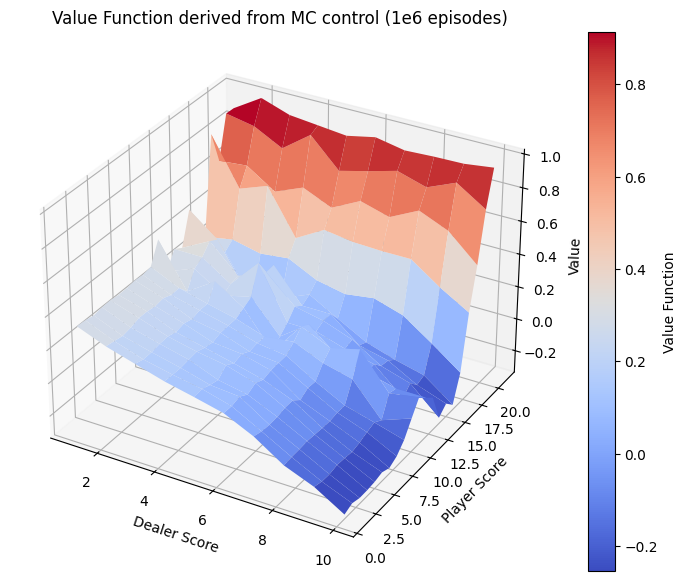

In [80]:
V = defaultdict(float)
for state, actions in Q_mc.items():
    action_value = np.max(actions)
    V[state] = action_value
visualize_value_function_3d(V, title="Value Function derived from MC control (1e6 episodes)")

## TD

In [ ]:
Q_true = Q_mc
lambda_values = np.arange(0.1, 1.0, 0.1)
Q_sarsa = {}
sarsa_policy = {}
mean_squared_error = np.empty(9)
for i, lambda_ in tqdm(enumerate(lambda_values)):
    Q_sarsa[lambda_], sarsa_policy[lambda_], mean_squared_error[i] = sarsa_lambda(env, 100_000, lambda_=lambda_)


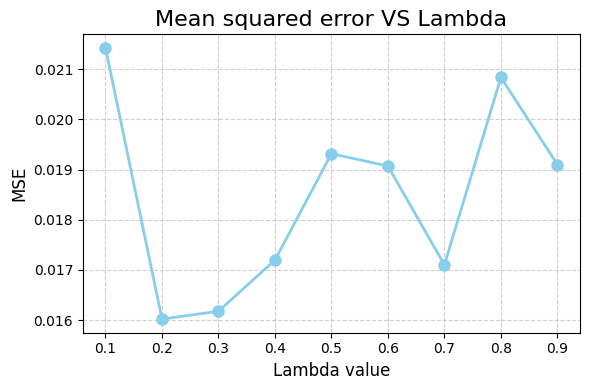

In [106]:
# Create a line plot with dots
plt.figure(figsize=(6, 4))
plt.plot(lambda_values, mean_squared_error, marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=8)

# Add labels and title
plt.title('Mean squared error VS Lambda', fontsize=16)
plt.xlabel('Lambda value', fontsize=12)
plt.ylabel('MSE', fontsize=12)

# Add grid for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
Q_sarsa_0, sarsa_policy_0, mse_0 = sarsa_lambda(env, 100_000, lambda_=0)
Q_sarsa_1, sarsa_policy_1, mse_1 = sarsa_lambda(env, 100_000, lambda_=1)

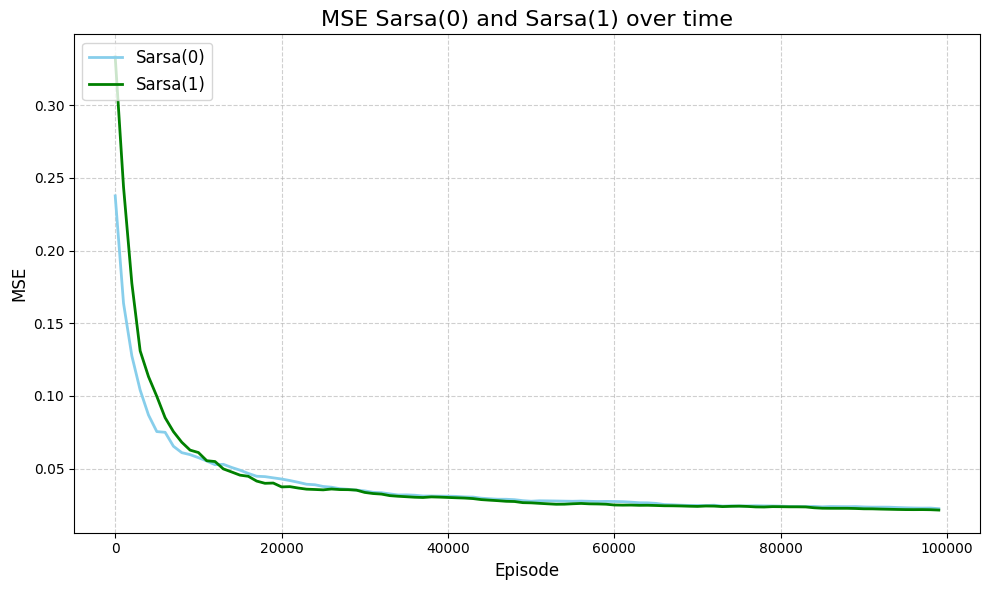

In [128]:
# Create a line plot with dots
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(mse_0)) * 1000, mse_0, color='skyblue', linestyle='-', linewidth=2, label="Sarsa(0)")
plt.plot(np.arange(len(mse_1)) * 1000, mse_1, color='green', linestyle='-', linewidth=2, label="Sarsa(1)")

# Add labels and title
plt.title('MSE Sarsa(0) and Sarsa(1) over time', fontsize=16)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('MSE', fontsize=12)

# Add legend
plt.legend(loc='upper left', fontsize=12)

# Add grid for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

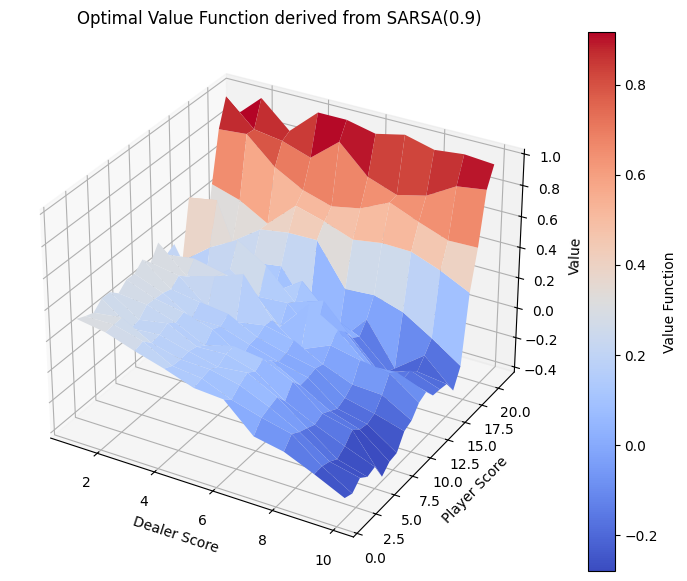

In [117]:
lambda_ = 0.9
V = defaultdict(float)
for state, actions in Q_sarsa[lambda_].items():
    action_value = np.max(actions)
    V[state] = action_value
visualize_value_function_3d(V, title=f"Optimal Value Function derived from SARSA({lambda_})")

## Q learning

In [25]:
Q_true = Q_mc
Q_q_learning, q_learning_policy = q_learning(env, 100_000)

  2%|▏         | 1773/100000 [00:00<00:22, 4408.42it/s]

Q_learning, iteration: 1000, MSE: 0.2947


  3%|▎         | 2652/100000 [00:00<00:22, 4342.78it/s]

Q_learning, iteration: 2000, MSE: 0.1888


  4%|▎         | 3528/100000 [00:00<00:22, 4285.83it/s]

Q_learning, iteration: 3000, MSE: 0.1384


  5%|▍         | 4798/100000 [00:01<00:23, 4136.28it/s]

Q_learning, iteration: 4000, MSE: 0.1154


  6%|▌         | 5623/100000 [00:01<00:23, 4089.64it/s]

Q_learning, iteration: 5000, MSE: 0.0909


  6%|▋         | 6475/100000 [00:01<00:22, 4149.41it/s]

Q_learning, iteration: 6000, MSE: 0.0822


  8%|▊         | 7721/100000 [00:01<00:22, 4047.32it/s]

Q_learning, iteration: 7000, MSE: 0.0731


  9%|▊         | 8558/100000 [00:02<00:22, 4095.71it/s]

Q_learning, iteration: 8000, MSE: 0.0663


 10%|▉         | 9836/100000 [00:02<00:21, 4122.04it/s]

Q_learning, iteration: 9000, MSE: 0.0585


 11%|█         | 10703/100000 [00:02<00:21, 4232.57it/s]

Q_learning, iteration: 10000, MSE: 0.0549


 12%|█▏        | 11549/100000 [00:02<00:21, 4103.83it/s]

Q_learning, iteration: 11000, MSE: 0.0505


 12%|█▏        | 12354/100000 [00:03<00:23, 3791.65it/s]

Q_learning, iteration: 12000, MSE: 0.049


 14%|█▎        | 13624/100000 [00:03<00:21, 4046.55it/s]

Q_learning, iteration: 13000, MSE: 0.0457


 15%|█▍        | 14872/100000 [00:03<00:20, 4111.03it/s]

Q_learning, iteration: 14000, MSE: 0.0435


 16%|█▌        | 15728/100000 [00:03<00:20, 4136.34it/s]

Q_learning, iteration: 15000, MSE: 0.042


 17%|█▋        | 16968/100000 [00:04<00:20, 3978.59it/s]

Q_learning, iteration: 16000, MSE: 0.0406


 18%|█▊        | 17820/100000 [00:04<00:19, 4126.17it/s]

Q_learning, iteration: 17000, MSE: 0.04


 19%|█▊        | 18645/100000 [00:04<00:19, 4079.47it/s]

Q_learning, iteration: 18000, MSE: 0.0388


 20%|█▉        | 19886/100000 [00:04<00:19, 4013.17it/s]

Q_learning, iteration: 19000, MSE: 0.0392


 21%|██        | 20711/100000 [00:05<00:19, 4063.77it/s]

Q_learning, iteration: 20000, MSE: 0.0381


 22%|██▏       | 21563/100000 [00:05<00:18, 4164.34it/s]

Q_learning, iteration: 21000, MSE: 0.0368


 22%|██▏       | 22404/100000 [00:05<00:18, 4091.60it/s]

Q_learning, iteration: 22000, MSE: 0.0356


 24%|██▎       | 23653/100000 [00:05<00:18, 4108.19it/s]

Q_learning, iteration: 23000, MSE: 0.0352


 25%|██▍       | 24908/100000 [00:06<00:18, 4159.92it/s]

Q_learning, iteration: 24000, MSE: 0.034


 25%|██▌       | 25325/100000 [00:06<00:18, 4081.95it/s]

Q_learning, iteration: 25000, MSE: 0.0342


 27%|██▋       | 26583/100000 [00:06<00:17, 4099.66it/s]

Q_learning, iteration: 26000, MSE: 0.0331


 28%|██▊       | 27820/100000 [00:06<00:17, 4086.29it/s]

Q_learning, iteration: 27000, MSE: 0.0324


 29%|██▊       | 28678/100000 [00:07<00:17, 4148.04it/s]

Q_learning, iteration: 28000, MSE: 0.0318


 30%|██▉       | 29538/100000 [00:07<00:16, 4215.62it/s]

Q_learning, iteration: 29000, MSE: 0.0321


 31%|███       | 30795/100000 [00:07<00:16, 4105.91it/s]

Q_learning, iteration: 30000, MSE: 0.0316


 32%|███▏      | 31627/100000 [00:07<00:16, 4045.73it/s]

Q_learning, iteration: 31000, MSE: 0.0312


 32%|███▏      | 32433/100000 [00:07<00:17, 3928.72it/s]

Q_learning, iteration: 32000, MSE: 0.0307


 34%|███▎      | 33689/100000 [00:08<00:16, 4110.95it/s]

Q_learning, iteration: 33000, MSE: 0.0305


 35%|███▍      | 34551/100000 [00:08<00:15, 4202.39it/s]

Q_learning, iteration: 34000, MSE: 0.0298


 36%|███▌      | 35805/100000 [00:08<00:15, 4117.81it/s]

Q_learning, iteration: 35000, MSE: 0.0298


 37%|███▋      | 36633/100000 [00:08<00:15, 4122.70it/s]

Q_learning, iteration: 36000, MSE: 0.0298


 38%|███▊      | 37875/100000 [00:09<00:15, 4082.80it/s]

Q_learning, iteration: 37000, MSE: 0.0299


 39%|███▊      | 38729/100000 [00:09<00:14, 4169.27it/s]

Q_learning, iteration: 38000, MSE: 0.0295


 40%|███▉      | 39580/100000 [00:09<00:14, 4204.04it/s]

Q_learning, iteration: 39000, MSE: 0.0291


 41%|████      | 40887/100000 [00:09<00:13, 4253.05it/s]

Q_learning, iteration: 40000, MSE: 0.0286


 42%|████▏     | 41750/100000 [00:10<00:13, 4239.89it/s]

Q_learning, iteration: 41000, MSE: 0.0281


 43%|████▎     | 42590/100000 [00:10<00:13, 4112.78it/s]

Q_learning, iteration: 42000, MSE: 0.0282


 44%|████▍     | 43880/100000 [00:10<00:13, 4228.57it/s]

Q_learning, iteration: 43000, MSE: 0.0283


 45%|████▍     | 44746/100000 [00:10<00:12, 4284.91it/s]

Q_learning, iteration: 44000, MSE: 0.0283


 46%|████▌     | 45625/100000 [00:11<00:12, 4202.90it/s]

Q_learning, iteration: 45000, MSE: 0.0284


 47%|████▋     | 46502/100000 [00:11<00:12, 4226.58it/s]

Q_learning, iteration: 46000, MSE: 0.0282


 48%|████▊     | 47831/100000 [00:11<00:12, 4333.82it/s]

Q_learning, iteration: 47000, MSE: 0.028


 49%|████▊     | 48693/100000 [00:11<00:12, 4153.93it/s]

Q_learning, iteration: 48000, MSE: 0.0277


 50%|████▉     | 49553/100000 [00:12<00:12, 4195.67it/s]

Q_learning, iteration: 49000, MSE: 0.0276


 51%|█████     | 50851/100000 [00:12<00:11, 4288.10it/s]

Q_learning, iteration: 50000, MSE: 0.0274


 52%|█████▏    | 51728/100000 [00:12<00:11, 4321.07it/s]

Q_learning, iteration: 51000, MSE: 0.0271


 53%|█████▎    | 52583/100000 [00:12<00:11, 4186.53it/s]

Q_learning, iteration: 52000, MSE: 0.0271


 53%|█████▎    | 53430/100000 [00:12<00:11, 4144.12it/s]

Q_learning, iteration: 53000, MSE: 0.027


 55%|█████▍    | 54749/100000 [00:13<00:10, 4178.41it/s]

Q_learning, iteration: 54000, MSE: 0.0269


 56%|█████▌    | 55636/100000 [00:13<00:10, 4304.45it/s]

Q_learning, iteration: 55000, MSE: 0.0267


 56%|█████▋    | 56485/100000 [00:13<00:10, 4092.83it/s]

Q_learning, iteration: 56000, MSE: 0.0266


 58%|█████▊    | 57762/100000 [00:14<00:10, 4204.49it/s]

Q_learning, iteration: 57000, MSE: 0.0267


 59%|█████▊    | 58623/100000 [00:14<00:10, 4128.26it/s]

Q_learning, iteration: 58000, MSE: 0.0265


 60%|█████▉    | 59515/100000 [00:14<00:09, 4291.89it/s]

Q_learning, iteration: 59000, MSE: 0.0262


 61%|██████    | 60839/100000 [00:14<00:09, 4346.10it/s]

Q_learning, iteration: 60000, MSE: 0.0262


 62%|██████▏   | 61714/100000 [00:14<00:08, 4347.49it/s]

Q_learning, iteration: 61000, MSE: 0.0261


 63%|██████▎   | 62584/100000 [00:15<00:08, 4328.03it/s]

Q_learning, iteration: 62000, MSE: 0.0259


 64%|██████▍   | 63898/100000 [00:15<00:08, 4325.31it/s]

Q_learning, iteration: 63000, MSE: 0.0256


 65%|██████▍   | 64788/100000 [00:15<00:08, 4372.98it/s]

Q_learning, iteration: 64000, MSE: 0.0254


 66%|██████▌   | 65662/100000 [00:15<00:07, 4331.02it/s]

Q_learning, iteration: 65000, MSE: 0.0253


 67%|██████▋   | 66526/100000 [00:16<00:07, 4209.11it/s]

Q_learning, iteration: 66000, MSE: 0.0251


 68%|██████▊   | 67828/100000 [00:16<00:07, 4274.41it/s]

Q_learning, iteration: 67000, MSE: 0.0251


 69%|██████▊   | 68686/100000 [00:16<00:07, 4186.83it/s]

Q_learning, iteration: 68000, MSE: 0.025


 70%|██████▉   | 69563/100000 [00:16<00:07, 4223.48it/s]

Q_learning, iteration: 69000, MSE: 0.0252


 71%|███████   | 70860/100000 [00:17<00:06, 4233.42it/s]

Q_learning, iteration: 70000, MSE: 0.0251
Q_learning, iteration: 71000, MSE: 0.025


 73%|███████▎  | 72597/100000 [00:17<00:06, 4282.79it/s]

Q_learning, iteration: 72000, MSE: 0.0249


 74%|███████▍  | 73889/100000 [00:17<00:06, 4292.58it/s]

Q_learning, iteration: 73000, MSE: 0.0249


 75%|███████▍  | 74757/100000 [00:18<00:05, 4246.12it/s]

Q_learning, iteration: 74000, MSE: 0.0249


 76%|███████▌  | 75620/100000 [00:18<00:05, 4243.61it/s]

Q_learning, iteration: 75000, MSE: 0.0247


 76%|███████▋  | 76474/100000 [00:18<00:05, 4154.96it/s]

Q_learning, iteration: 76000, MSE: 0.0246


 78%|███████▊  | 77814/100000 [00:18<00:05, 4328.88it/s]

Q_learning, iteration: 77000, MSE: 0.0246


 79%|███████▊  | 78677/100000 [00:18<00:05, 4258.72it/s]

Q_learning, iteration: 78000, MSE: 0.0246


 80%|███████▉  | 79535/100000 [00:19<00:04, 4219.98it/s]

Q_learning, iteration: 79000, MSE: 0.0246


 81%|████████  | 80856/100000 [00:19<00:04, 4308.19it/s]

Q_learning, iteration: 80000, MSE: 0.0245


 82%|████████▏ | 81754/100000 [00:19<00:04, 4399.37it/s]

Q_learning, iteration: 81000, MSE: 0.0245


 83%|████████▎ | 82658/100000 [00:19<00:03, 4429.24it/s]

Q_learning, iteration: 82000, MSE: 0.0243


 84%|████████▎ | 83556/100000 [00:20<00:03, 4391.14it/s]

Q_learning, iteration: 83000, MSE: 0.0242


 85%|████████▍ | 84893/100000 [00:20<00:03, 4431.18it/s]

Q_learning, iteration: 84000, MSE: 0.0242


 86%|████████▌ | 85779/100000 [00:20<00:03, 4340.38it/s]

Q_learning, iteration: 85000, MSE: 0.0242


 87%|████████▋ | 86658/100000 [00:20<00:03, 4321.57it/s]

Q_learning, iteration: 86000, MSE: 0.0242


 88%|████████▊ | 87522/100000 [00:20<00:02, 4269.53it/s]

Q_learning, iteration: 87000, MSE: 0.0242


 89%|████████▉ | 88855/100000 [00:21<00:02, 4367.06it/s]

Q_learning, iteration: 88000, MSE: 0.0242


 90%|████████▉ | 89751/100000 [00:21<00:02, 4430.42it/s]

Q_learning, iteration: 89000, MSE: 0.0241


 91%|█████████ | 90637/100000 [00:21<00:02, 4256.20it/s]

Q_learning, iteration: 90000, MSE: 0.0242


 92%|█████████▏| 91513/100000 [00:21<00:01, 4316.17it/s]

Q_learning, iteration: 91000, MSE: 0.024


 93%|█████████▎| 92823/100000 [00:22<00:01, 4347.23it/s]

Q_learning, iteration: 92000, MSE: 0.0238


 94%|█████████▎| 93713/100000 [00:22<00:01, 4365.16it/s]

Q_learning, iteration: 93000, MSE: 0.0238


 95%|█████████▍| 94629/100000 [00:22<00:01, 4416.68it/s]

Q_learning, iteration: 94000, MSE: 0.0237


 96%|█████████▌| 95948/100000 [00:22<00:00, 4314.57it/s]

Q_learning, iteration: 95000, MSE: 0.0237


 97%|█████████▋| 96858/100000 [00:23<00:00, 4427.21it/s]

Q_learning, iteration: 96000, MSE: 0.0236


 98%|█████████▊| 97763/100000 [00:23<00:00, 4450.46it/s]

Q_learning, iteration: 97000, MSE: 0.0235


 99%|█████████▊| 98667/100000 [00:23<00:00, 4295.54it/s]

Q_learning, iteration: 98000, MSE: 0.0235
Q_learning, iteration: 99000, MSE: 0.0234


100%|██████████| 100000/100000 [00:23<00:00, 4192.24it/s]

Q_learning, iteration: 100000, MSE: 0.0232


## Other

In [81]:
V_static = monte_carlo_prediction(static_policy, env, num_episodes=1_000_000)
V_random = monte_carlo_prediction(random_policy, env, num_episodes=1_000_000)
# pprint(V)

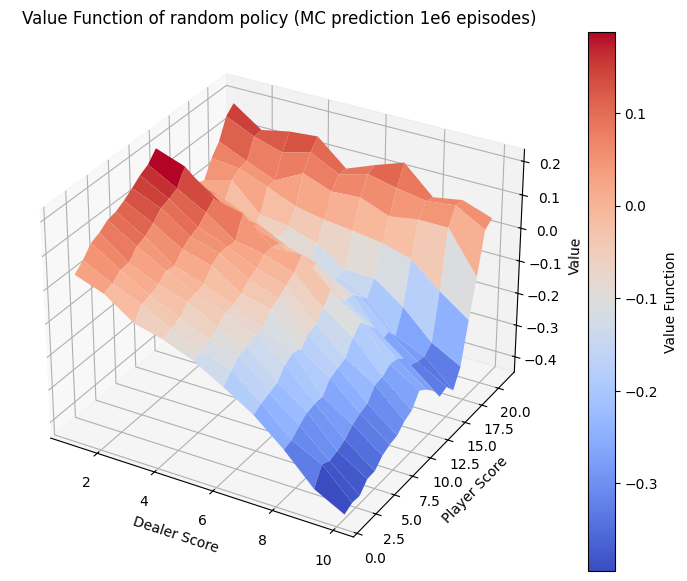

In [84]:
visualize_value_function_3d(V_random, title="Value Function of random policy (MC prediction 1e6 episodes)")

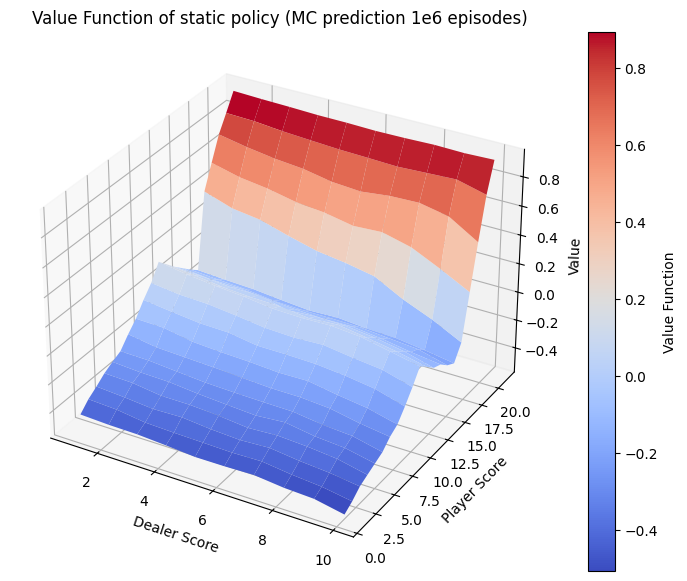

In [85]:
visualize_value_function_3d(V_static, title="Value Function of static policy (MC prediction 1e6 episodes)")

# Compare different policies

In [131]:
def mc_full_policy(state):
    probs = mc_policy(state)
    action = np.random.choice(len(probs), p=probs)
    return action

In [132]:
def sarsa_full_policy(state):
    probs = sarsa_policy[0.2](state)
    action = np.random.choice(len(probs), p=probs)
    return action

In [135]:
policies = [mc_full_policy, sarsa_full_policy, static_policy, random_policy]
num_episodes = 100_000
max_steps = 100
for policy in policies:
    total_reward = 0
    dealer_win_count = 0
    player_win_count = 0
    draw_count = 0
    for i_episode in range(num_episodes):

        state = env.reset()
        for t_step in range(max_steps):
            action = policy(state)
            state, reward, is_terminal = env.step(state, action)
            total_reward += reward
            if is_terminal:
                break

        match reward:
            case 1:
                player_win_count += 1
            case -1:
                dealer_win_count += 1
            case 0:
                draw_count += 1
                
    print(f"Policy: {policy.__name__}, total reward: {total_reward}, mean reward: {round(total_reward / num_episodes, 4)}")
    print(f"Dealer win: {dealer_win_count}")
    print(f"Player win: {player_win_count}")
    print(f"Draw: {draw_count}")

Policy: mc_full_policy, total reward: 4837, mean reward: 0.0484
Dealer win: 47436
Player win: 52273
Draw: 291
Policy: sarsa_full_policy, total reward: 3808, mean reward: 0.0381
Dealer win: 47925
Player win: 51733
Draw: 342
Policy: static_policy, total reward: -26549, mean reward: -0.2655
Dealer win: 60850
Player win: 34301
Draw: 4849
Policy: random_policy, total reward: -10454, mean reward: -0.1045
Dealer win: 54976
Player win: 44522
Draw: 502


# To Do

1. Understand and implement off-policy for MC and TD (+Q-learning)
2. Watch lecture 6: function approximation
3. Implement function approximation